In [1]:
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm, tqdm_notebook

import numpy as np

from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors        import NearestNeighbors

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from torch.utils.data.dataset import random_split
from torchvision              import datasets 
from torchvision              import transforms

# General settings and normalization tools

In [2]:
do_train          = False
do_eval           = False
calib_prop        = 0.8
model_path        = '../models/CIFAR_CNN.pt'
batch_size        = 128
device            = torch.device('cuda')
means             = torch.tensor((0.4914, 0.4822, 0.4465)).to(device)
stds              = torch.tensor((0.2023, 0.1994, 0.2010)).to(device)
normalize         = lambda x: (x - means) / stds
normalize_red     = lambda x: (x - means[0]) / stds[0]
normalize_green   = lambda x: (x - means[1]) / stds[1]
normalize_blue    = lambda x: (x - means[2]) / stds[2]
reverse_normalize = lambda x: (x * stds) + means

In [3]:
def display_img(img):
    img_data = lambda img: reverse_normalize(img.squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
    plt.imshow(img_data(img))    

# Data loading

In [4]:
cifar_cats = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [5]:
training_dataset = datasets.CIFAR10(
    '../data',
    train = True,
    download = True,
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]
    )
)

train_set_size               = len(training_dataset)
calib_size                   = round(calib_prop * train_set_size)
train_dataset, calib_dataset = random_split(
    dataset = training_dataset, 
    lengths = [train_set_size - calib_size, calib_size]
)
print(f'Train dataset size: {len(train_dataset)}')
print(f'Calibration dataset size: {len(calib_dataset)}')

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle = True,
    batch_size = batch_size
)

Files already downloaded and verified
Train dataset size: 10000
Calibration dataset size: 40000


In [6]:
test_dataset = datasets.CIFAR10(
    '../data',
    train = False,
    download = True,
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]
    )
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle = False,
    batch_size = 2 * batch_size
)

Files already downloaded and verified


truck


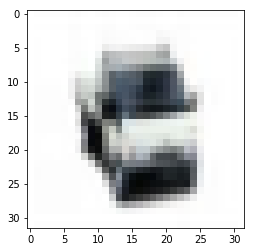

In [7]:
img, y = train_dataset[510]
display_img(img.to(device))
print(cifar_cats[y])

dog


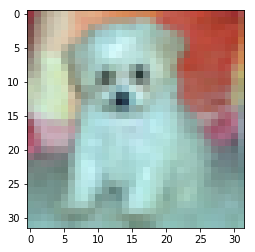

In [8]:
img, y = test_dataset[510]
display_img(img.to(device))
print(cifar_cats[y])

# Training and evaluation tools

In [9]:
def train(model, device, train_loader, optimizer, criterion, n_epochs, log_interval):
    model.train()
    for epoch in tqdm_notebook(range(n_epochs), desc = 'Epochs'):
        for batch_idx, (X, y) in tqdm_notebook(enumerate(train_loader), total = len(train_loader), desc = 'Batches', leave = False):
            X, y       = X.to(device), y.to(device)
            optimizer.zero_grad()
            *_, y_pred = model(X)
            loss       = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(f'Train epoch {epoch}: [{batch_idx * len(X):5d}/{len(train_loader.dataset):5d}] Loss: {loss.item():7.4f}')

In [10]:
def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_set_size = len(test_loader.dataset)
    correct_answers = 0
    sum_loss = 0
    with torch.no_grad():
        for X, y in tqdm_notebook(test_loader):
            X, y             = X.to(device), y.to(device)
            *_, y_pred       = model(X)
            class_pred       = y_pred.argmax(dim = 1)
            correct_answers += (y == class_pred).sum().item()
            sum_loss        += criterion(y_pred, y).item()
    accuracy = correct_answers / test_set_size
    average_loss = sum_loss / len(test_loader)
    
    return accuracy, average_loss

# Model

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3 , 16 , 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 16 , 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 32,  3, padding = 1)
        self.conv4 = nn.Conv2d(32, 32,  3, padding = 1)
        self.fc1   = nn.Linear(32 * 8 * 8, 128)
        self.fc2   = nn.Linear(128       , 10)
        
    def forward(self, x):
        out_conv1 = F.dropout(F.relu(self.conv1(x)), 0.2, training = self.training)
        out_conv2 = F.dropout(F.relu(self.conv2(out_conv1)), 0.2, training = self.training)
        out_pool1 = F.max_pool2d(out_conv2, kernel_size = (2, 2))
        out_conv3 = F.dropout(F.relu(self.conv3(out_pool1)), 0.2, training = self.training)
        out_conv4 = F.dropout(F.relu(self.conv4(out_conv3)), 0.2, training = self.training)
        out_pool2 = F.max_pool2d(out_conv4, kernel_size = (2, 2))
        out_view  = out_pool2.view(-1, 32 * 8 * 8)
        out_fc    = F.dropout(F.relu(self.fc1(out_view)), 0.2, training = self.training)
        out       = self.fc2(out_fc)
        
        return out_conv1, out_conv2, out_conv3, out_conv4, out

# Training

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
if do_train:
    cnn       = CNN().to(device)
    optimizer = optim.Adam(cnn.parameters())
    train(cnn, device, train_loader, optimizer, criterion, 15, len(train_loader) // 5)
    torch.save(cnn.state_dict(), model_path)

In [14]:
cnn = CNN().to(device)
cnn.load_state_dict(torch.load(model_path))
cnn.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
if do_eval:
    accuracy, avg_loss = evaluate(cnn, device, train_loader, criterion)
    print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
    accuracy, avg_loss = evaluate(cnn, device, test_loader, criterion)
    print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

Real label: 1
Predicted label: 1


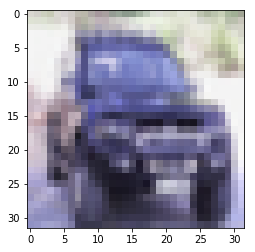

In [16]:
ex_id = 9
X, y  = test_dataset[ex_id]
X     = X.to(device)
img   = X.permute(1, 2, 0)
img   = reverse_normalize(img)
plt.imshow(img.cpu())
print(f'Real label: {y}')
print(f'Predicted label: {cnn(X.unsqueeze(0))[-1].argmax().item()}')

# Deep KNN

In [44]:
class DeepKNN():
    def __init__(self, model, device, train_dataset, calib_dataset, 
                 batch_size, n_neighbors, n_embs):
        self.model         = model
        self.device        = device
        self.train_dataset = train_dataset
        self.calib_dataset = calib_dataset
        self.batch_size    = batch_size
        self.n_neighbors   = n_neighbors
        self.n_embs        = n_embs
        (
            self.conv_features, 
            self.train_targets, 
            self.train_predictions
        )                  = self._build_emb_spaces()
        self._build_calibration()
        self.neighs = self._build_neighs()
        
    def _build_emb_spaces(self):
        print('Building the embedding spaces from the training set.')
        sequential_train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            shuffle    = False,
            batch_size = self.batch_size
        )
        
        conv_features = [[] for _ in range(self.n_embs)]
        targets       = []
        predictions   = []
        print('\tRunning predictions')
        self.model.eval()
        for X, y in sequential_train_loader:
            X                  = X.to(self.device)
            *out_convs, y_pred = self.model(X)
            for i, out_conv in enumerate(out_convs):
                conv_feat = out_conv.view(out_conv.size(0), -1).cpu().detach().numpy()
                conv_features[i].append(conv_feat)
            targets.append(y.numpy())
            predictions.append(y_pred.cpu().detach().numpy())
        print('\tConcatenating results')
        conv_features = [np.concatenate(out_convs) for out_convs in conv_features]
        targets       = np.concatenate(targets)
        predictions   = np.concatenate(predictions, axis = 0)
        
        return conv_features, targets, predictions

    def _build_calibration(self):
        # TODO
        calib_loader = torch.utils.data.DataLoader(
            self.calib_dataset,
            shuffle = False,
            batch_size = batch_size
        )
    
    def _build_neighs(self):
        print('Building Nearest Neighbor finders.')
        return [
            NearestNeighbors(
                n_neighbors = self.n_neighbors, 
                metric      = 'cosine'
            ).fit(feats) 
            for feats in self.conv_features
        ]
        
    def _alpha(self, X, y):
        neighbors_by_layer, _  = self._get_closest_points(X)
        closest_points_classes = self.train_targets[neighbors_by_layer]
        
        return (closest_points_classes != y).sum()
        
    def _get_closest_points(self, X):
        *out_convs, y_pred = self.model(X.unsqueeze(0).to(device))
        neighbors_by_layer = []
        for i, (neigh, layer_emb) in enumerate(zip(self.neighs, out_convs)):
            emb       = layer_emb.detach().cpu().view(1, -1).numpy()
            neighbors = neigh.kneighbors(emb, return_distance = False) 
            neighbors_by_layer.append(neighbors)
        
        return np.concatenate(neighbors_by_layer, axis = 0), y_pred
    
    def predict_interpretation(self, X, y = None):
        img_data = lambda img: reverse_normalize(img.to(device).squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
        plt.figure(figsize = (12, 6))
        gs       = gridspec.GridSpec(4, 8)
        ax_big   = plt.subplot(gs[:, :-4])
        ax_grid  = [[plt.subplot(gs[i, j]) for j in range(4, 8)] for i in range(4)]
        ax_big.imshow(img_data(X))
        ax_big.axis('off')
        neighbors_by_layer, y_pred = self._get_closest_points(X)
        for i, closest_layer in enumerate(neighbors_by_layer):
            for j, train_ex_id in enumerate(closest_layer):
                img = self.train_dataset[train_ex_id][0]
                ax_grid[i][j].imshow(img_data(img))
                ax_grid[i][j].axis('off')

        if y is not None:
            print(f'Real class: {cifar_cats[y]}')
        print(f'Predicted class: {cifar_cats[y_pred.argmax(dim = 1).cpu().item()]}')
        
        return y_pred

In [45]:
deep_knn = DeepKNN(
    model         = cnn, 
    device        = device, 
    train_dataset = train_dataset,
    calib_dataset = calib_dataset,
    batch_size    = batch_size,
    n_neighbors   = 4,
    n_embs        = 4 
)

Building the embedding spaces from the training set.
	Running predictions
	Concatenating results
Building Nearest Neighbor finders.


In [46]:
deep_knn._alpha(*test_dataset[1])

4

Real class: ship
Predicted class: ship


tensor([[  6.3778,   6.8113,  -7.2254,  -8.9941, -11.6314, -12.7672, -12.0315,
         -13.9200,  11.7927,  -1.2883]], device='cuda:0',
       grad_fn=<AddmmBackward>)

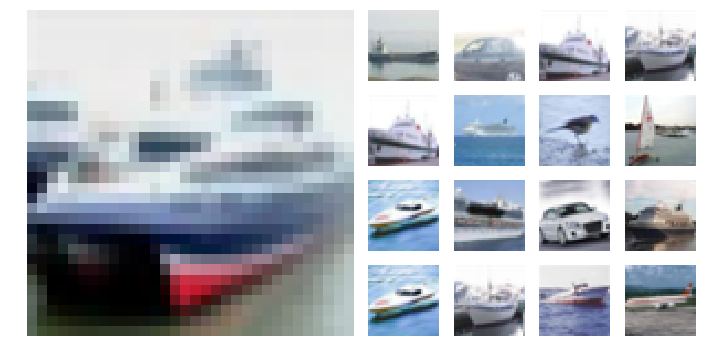

In [19]:
deep_knn.predict_interpretation(*test_dataset[1])

In [33]:
result, y_pred = deep_knn._get_closest_points(test_dataset[1][0])

In [34]:
result

array([[9268, 2477, 5438, 8306],
       [5438, 1608, 5967, 3559],
       [1701,  862, 5543, 1999],
       [1701, 8306, 3526, 6085]])

In [36]:
classes = deep_knn.train_targets[result]

In [38]:
y = 8

In [39]:
(classes != y).sum()

4

In [40]:
classes

array([[8, 1, 8, 8],
       [8, 8, 2, 8],
       [8, 8, 1, 8],
       [8, 8, 8, 0]])

In [32]:
result

(array([[9268, 2477, 5438, 8306],
        [5438, 1608, 5967, 3559],
        [1701,  862, 5543, 1999],
        [1701, 8306, 3526, 6085]]),
 tensor([[  6.3778,   6.8113,  -7.2254,  -8.9941, -11.6314, -12.7672, -12.0315,
          -13.9200,  11.7927,  -1.2883]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [28]:
deep_knn.train_targets

array([6, 4, 2, ..., 2, 0, 6])

# Adversarial examples

In [23]:
def generate_adv_example(model, epsilon, criterion, X):
    X.requires_grad = True
    *_, y_pred      = model(X)
    loss            = criterion(y_pred, y_pred.argmax(dim = 1))
    loss.backward()
    adv_example     = X + epsilon * X.grad.sign()
    
    # Clamping the result to [0, 1] in each channel.
    # I don't think that there exist a multidimensional clamp function.
    for channel, norm_func in enumerate([normalize_red, normalize_green, normalize_blue]):
        adv_example[:, channel, ...].clamp_(norm_func(0), norm_func(1))
    
    return adv_example

In [24]:
def adv_sample_process(model, epsilon, X, y):
    source       = X.unsqueeze(0).to(device)
    *_, y_pred   = model(source)
    adv_example  = generate_adv_example(model, epsilon, criterion, source)
    *_, adv_pred = cnn(adv_example)
    for i in range(10):
        print(f'Class {i}: {y_pred[0, i]:6.4f} \t->\t {adv_pred[0, i]:^6.4f}')
    plt.figure(figsize = (15, 10))
    plt.subplot(1, 2, 1)
    display_img(source)
    plt.subplot(1, 2, 2)
    display_img(adv_example)
    print(f'Real label: {cifar_cats[y]}')
    print(f'Predicted label: {cifar_cats[adv_pred[0].argmax().item()]}')

Class 0: -4.0491 	->	 -3.4603
Class 1: -5.2417 	->	 -4.0262
Class 2: -0.6231 	->	 -1.4116
Class 3: 2.4321 	->	 2.6080
Class 4: -1.2117 	->	 -0.6302
Class 5: 1.4921 	->	 2.2423
Class 6: 3.7670 	->	 -0.9584
Class 7: -2.4866 	->	 1.0435
Class 8: -5.2885 	->	 -5.2924
Class 9: -3.1335 	->	 -3.9634
Real label: frog
Predicted label: cat


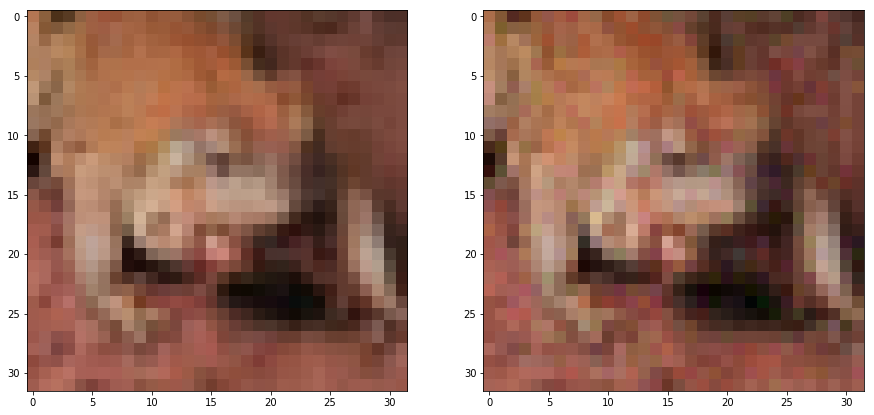

In [25]:
ex_id = 5
X, y = test_dataset[ex_id]
adv_sample_process(cnn, 0.15, X, y)

# Nearest neighbors experiments

In [ ]:
# neighs = [NearestNeighbors(n_neighbors = 5, metric = 'cosine').fit(feats) for feats in conv_features]

In [ ]:
# def display_knn_interpretation(model, X, y, train_data, neighs):
#     img_data = lambda img: reverse_normalize(img.to(device).squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
#     plt.figure(figsize = (12, 6))
#     gs       = gridspec.GridSpec(4, 8)
#     ax_big   = plt.subplot(gs[:, :-4])
#     ax_grid  = [[plt.subplot(gs[i, j]) for j in range(4, 8)] for i in range(4)]
#     ax_big.imshow(img_data(X))
#     ax_big.axis('off')
#     *out_convs, y_pred = model(X.unsqueeze(0).to(device))
#     for i, (neigh, layer_emb) in enumerate(zip(neighs, out_convs)):
#         emb = layer_emb.detach().cpu().view(1, -1).numpy()
#         neighbors = neigh.kneighbors(emb, return_distance = False) 
#         for j, neighbor_id in enumerate(neighbors[0, 1:]):
#             ax_grid[i][j].imshow(img_data(train_data[neighbor_id][0]))
#             ax_grid[i][j].axis('off')
#     print(f'Real class: {cifar_cats[y]}')
#     print(f'Predicted class: {cifar_cats[y_pred.argmax(dim = 1).cpu().item()]}')

In [ ]:
# example_id = 5

In [ ]:
# display_knn_interpretation(cnn, *test_dataset[example_id], train_dataset, neighs)

In [ ]:
# img, target = test_dataset[example_id]
# adv_img = generate_adv_example(cnn, 0.15, criterion, img.unsqueeze(0).to(device))
# display_knn_interpretation(cnn, adv_img[0], target, train_dataset, neighs)